# RiverPredictorModel

This model aims to predict select data from usgs river datasets.
This version isn't really aiming for performance, just something built on currently limited data.
It'll be nice to get a wider range of data and come back.

## Fetching Data
Let's use the data utility we've already built for the ingest service.

In [2]:
import sys
sys.path.insert(1,'../Fetch/')
import WaterServices

In [3]:
import numpy

In [4]:
sites = ["02336300", "02336030", "02336093", "02336106"]
print(WaterServices)
res = [WaterServices.getData(x) for x in sites]

<module 'WaterServices' from '../Fetch/WaterServices.py'>
https://waterdata.usgs.gov/ga/nwis/uv?format=rdb&site_no=02336300&period=1
FLOAT ERR 
FLOAT ERR 
FLOAT ERR 
FLOAT ERR 
FLOAT ERR 
FLOAT ERR 
FLOAT ERR 
FLOAT ERR 
FLOAT ERR 
FLOAT ERR 
FLOAT ERR 
FLOAT ERR 
FLOAT ERR 
FLOAT ERR 
FLOAT ERR 
https://waterdata.usgs.gov/ga/nwis/uv?format=rdb&site_no=02336030&period=1
https://waterdata.usgs.gov/ga/nwis/uv?format=rdb&site_no=02336093&period=1
https://waterdata.usgs.gov/ga/nwis/uv?format=rdb&site_no=02336106&period=1


In [5]:
import pandas
df0 = pandas.DataFrame(res[0])
df1 = pandas.DataFrame(res[1])
df2 = pandas.DataFrame(res[2])
df3 = pandas.DataFrame(res[3])
df0.sort_values(by='datetime')
df1.sort_values(by='datetime')
df2.sort_values(by='datetime')
df3.sort_values(by='datetime')


,agency_cd,site_no,datetime,tz_cd,GageHeight,Precipitation
0,USGS,02336106,2022-01-12 00:00,EST,2.57,0.0
1,USGS,02336106,2022-01-12 00:15,EST,2.57,0.0
2,USGS,02336106,2022-01-12 00:30,EST,2.57,0.0
3,USGS,02336106,2022-01-12 00:45,EST,2.57,0.0
4,USGS,02336106,2022-01-12 01:00,EST,2.57,0.0
...,...,...,...,...,...,...
177,USGS,02336106,2022-01-13 20:15,EST,2.54,0.0
178,USGS,02336106,2022-01-13 20:30,EST,2.54,0.0
179,USGS,02336106,2022-01-13 20:45,EST,2.55,0.0
180,USGS,02336106,2022-01-13 21:00,EST,2.54,0.0


In [6]:
def toTrainData(df):
    # GageHeight, Precipitation, Temperature, Turbidity
    a = [[x.get('GageHeight', -1), x.get('Precipitation', -1), x.get("Temperature", -1), x.get("Turbidity", -1)] for x in df.to_dict('records')]
    b = numpy.array(a)
    b[b== ''] = -1
    return b.astype(numpy.float32)

In [7]:
toTrainData(df0)

array([[ 2.6 ,  0.  ,  7.  ,  5.  ],
       [ 2.59,  0.  ,  6.9 ,  4.9 ],
       [ 2.59,  0.  ,  6.9 ,  4.9 ],
       [ 2.59,  0.  ,  6.9 ,  4.9 ],
       [ 2.59,  0.  ,  6.8 ,  4.9 ],
       [ 2.59,  0.  ,  6.8 ,  4.6 ],
       [ 2.59,  0.  ,  6.8 ,  4.7 ],
       [ 2.59,  0.  ,  6.7 ,  4.7 ],
       [ 2.59,  0.  ,  6.7 ,  4.8 ],
       [ 2.59,  0.  ,  6.6 ,  4.9 ],
       [ 2.59,  0.  ,  6.6 ,  4.8 ],
       [ 2.59,  0.  ,  6.6 ,  4.5 ],
       [ 2.59,  0.  ,  6.5 ,  4.4 ],
       [ 2.59,  0.  ,  6.5 ,  4.9 ],
       [ 2.59,  0.  ,  6.4 ,  4.7 ],
       [ 2.59,  0.  ,  6.4 ,  4.7 ],
       [ 2.6 ,  0.  ,  6.4 ,  4.5 ],
       [ 2.59,  0.  ,  6.3 ,  4.4 ],
       [ 2.59,  0.  ,  6.3 ,  4.4 ],
       [ 2.58,  0.  ,  6.2 ,  4.6 ],
       [ 2.58,  0.  ,  6.2 ,  4.4 ],
       [ 2.58,  0.  ,  6.2 ,  4.3 ],
       [ 2.58,  0.  ,  6.1 ,  4.4 ],
       [ 2.58,  0.  ,  6.1 ,  4.4 ],
       [ 2.59,  0.  ,  6.  ,  4.3 ],
       [ 2.58,  0.  ,  6.  ,  4.2 ],
       [ 2.59,  0.  ,  6.  ,  4.1 ],
 

## Model
Let's use keras, because why not :)
This data seems to lend itself to a sequence model.

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled0 = scaler.fit_transform(toTrainData(df0))
scaled1 = scaler.fit_transform(toTrainData(df1))
# df2 isn't useful to us since it has no gage height
scaled3 = scaler.fit_transform(toTrainData(df3))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


In [52]:
def split_sequence(sequence, look_back, forecast_horizon):
 X, y = list(), list()
 for i in range(len(sequence)): 
   lag_end = i + look_back
   forecast_end = lag_end + forecast_horizon
   if forecast_end > len(sequence):
     break
   seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
   X.append(seq_x)
   y.append(seq_y)
 return numpy.array(X), numpy.array(y)

LOOK_BACK = 20
FORECAST_RANGE = 1
SPLIT = 100

x0,y0 = split_sequence(scaled0[:SPLIT,:], LOOK_BACK, FORECAST_RANGE)
x1,y1 = split_sequence(scaled1[:SPLIT,:], LOOK_BACK, FORECAST_RANGE)
x3,y3 = split_sequence(scaled3[:SPLIT,:], LOOK_BACK, FORECAST_RANGE)
x0t,y0t = split_sequence(scaled0[SPLIT:,:], LOOK_BACK, FORECAST_RANGE)
x1t,y1t = split_sequence(scaled1[SPLIT:,:], LOOK_BACK, FORECAST_RANGE)
x3t,y3t = split_sequence(scaled3[SPLIT:,:], LOOK_BACK, FORECAST_RANGE)
print(x0.shape, x1.shape, x3.shape)
print(y0.shape, y1.shape, y3.shape)
print(x0t.shape, x1t.shape, x3t.shape)
print(y0t.shape, y1t.shape, y3t.shape)

(80, 20, 4) (80, 20, 4) (80, 20, 4)
(80, 1, 4) (80, 1, 4) (80, 1, 4)
(61, 20, 4) (61, 20, 4) (62, 20, 4)
(61, 1, 4) (61, 1, 4) (62, 1, 4)


In [53]:
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(LOOK_BACK, 4)))
model.add(RepeatVector(FORECAST_RANGE))
model.add(LSTM(10, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(4)))
model.compile(loss='mae', optimizer='adam')

In [54]:
history0 = model.fit(x0, y0, epochs=50, batch_size=20, validation_data=(x0t, y0t), verbose=2, shuffle=False)
history1 = model.fit(x1, y1, epochs=50, batch_size=20, validation_data=(x1t, y1t), verbose=2, shuffle=False)
history3 = model.fit(x3, y3, epochs=50, batch_size=20, validation_data=(x3t, y3t), verbose=2, shuffle=False)

Epoch 1/50
4/4 - 2s - loss: 0.4090 - val_loss: 0.3395
Epoch 2/50
4/4 - 0s - loss: 0.4038 - val_loss: 0.3344
Epoch 3/50
4/4 - 0s - loss: 0.3991 - val_loss: 0.3295
Epoch 4/50
4/4 - 0s - loss: 0.3943 - val_loss: 0.3251
Epoch 5/50
4/4 - 0s - loss: 0.3898 - val_loss: 0.3209
Epoch 6/50
4/4 - 0s - loss: 0.3853 - val_loss: 0.3168
Epoch 7/50
4/4 - 0s - loss: 0.3811 - val_loss: 0.3125
Epoch 8/50
4/4 - 0s - loss: 0.3771 - val_loss: 0.3083
Epoch 9/50
4/4 - 0s - loss: 0.3730 - val_loss: 0.3041
Epoch 10/50
4/4 - 0s - loss: 0.3690 - val_loss: 0.2997
Epoch 11/50
4/4 - 0s - loss: 0.3648 - val_loss: 0.2952
Epoch 12/50
4/4 - 0s - loss: 0.3605 - val_loss: 0.2906
Epoch 13/50
4/4 - 0s - loss: 0.3559 - val_loss: 0.2858
Epoch 14/50
4/4 - 0s - loss: 0.3511 - val_loss: 0.2807
Epoch 15/50
4/4 - 0s - loss: 0.3459 - val_loss: 0.2754
Epoch 16/50
4/4 - 0s - loss: 0.3403 - val_loss: 0.2696
Epoch 17/50
4/4 - 0s - loss: 0.3342 - val_loss: 0.2632
Epoch 18/50
4/4 - 0s - loss: 0.3273 - val_loss: 0.2563
Epoch 19/50
4/4 - 0

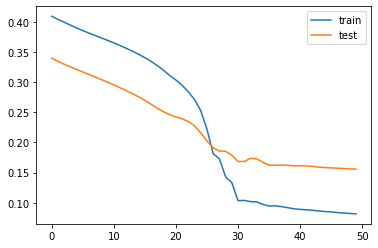

In [55]:
from matplotlib import pyplot
pyplot.plot(history0.history['loss'], label='train')
pyplot.plot(history0.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

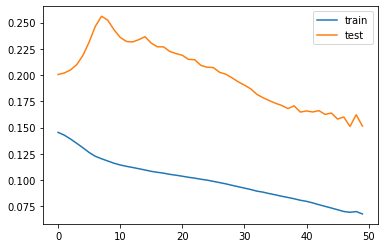

In [56]:
pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

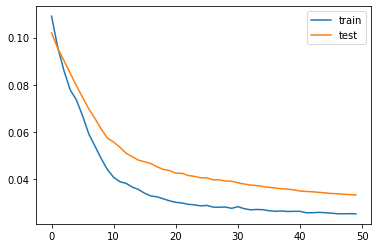

In [57]:
pyplot.plot(history3.history['loss'], label='train')
pyplot.plot(history3.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Predictions

In [58]:
def inverse_transform(y_test, yhat):
 y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
 yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
 yhat_inverse = scaler.inverse_transform(yhat_reshaped)
 y_test_inverse = scaler.inverse_transform(y_test_reshaped)
 return yhat_inverse, y_test_inverse

In [59]:
yhat = model.predict(x1t, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y1t, yhat)

In [67]:
yhat_inverse

array([[ 2.55291533e+00, -3.53573542e-03, -1.02548718e+00,
        -9.83375430e-01],
       [ 2.55334091e+00, -7.63983559e-03, -1.03967965e+00,
        -9.85092521e-01],
       [ 2.55286932e+00, -1.03708459e-02, -1.03940821e+00,
        -9.90681589e-01],
       [ 2.55255914e+00, -1.20196873e-02, -1.04173684e+00,
        -9.93493140e-01],
       [ 2.55377197e+00, -1.37061579e-02, -1.06769562e+00,
        -9.88605559e-01],
       [ 2.55494261e+00, -1.22521045e-02, -1.07213998e+00,
        -9.85436916e-01],
       [ 2.55504847e+00, -1.22954780e-02, -1.06860030e+00,
        -9.87315655e-01],
       [ 2.55549407e+00, -1.15223313e-02, -1.06554389e+00,
        -9.87951875e-01],
       [ 2.55584764e+00, -1.09825106e-02, -1.06237090e+00,
        -9.88858104e-01],
       [ 2.55600739e+00, -1.13036940e-02, -1.06263351e+00,
        -9.88939345e-01],
       [ 2.55596399e+00, -1.37033081e-02, -1.06196475e+00,
        -9.91406262e-01],
       [ 2.55591583e+00, -1.74605288e-02, -1.06327736e+00,
      

In [83]:
print(yhat_inverse[-1,0], y_test_inverse[-1,0]) # prediction vs last observed
df0.iloc[-1]

2.5584378 2.57


agency_cd                    USGS
site_no                  02336300
datetime         2022-01-13 21:00
tz_cd                         EST
Discharge                    42.2
GageHeight                   2.54
Temperature                     8
Conductance                   165
DO                           10.8
pH                            7.3
Turbidity                     2.2
Precipitation                   0
Name: 180, dtype: object

In [82]:
import datetime
print(df0.iloc[-1]['datetime'])
new_time = datetime.datetime.strptime(df0.iloc[-1]['datetime'], "%Y-%m-%d %H:%M") + datetime.timedelta(minutes=15)
str(new_time)

2022-01-13 21:00


'2022-01-13 21:15:00'

In [85]:
prediction_result = {"value": yhat_inverse[-1,0] - y_test_inverse[-1,0], "datetime": new_time, "site": df0.iloc[-1]['site_no'], "type":"gageHeight"}

In [86]:
print(prediction_result)

{'value': -0.011562109, 'datetime': datetime.datetime(2022, 1, 13, 21, 15), 'site': '02336300', 'type': 'gageHeight'}
